# Notes
This Jupyter Notebook provides you with some basic scaffolding to get you started on the [A2: Gesture Recognizer assignment](https://canvas.uw.edu/courses/1199409/assignments/4176980). In particular, I wrote some parser code and some initial data structures to parse and load the gesture logs recorded with the [A2: Gesture Logger](https://github.com/jonfroehlich/CSE590Sp2018/tree/master/A02-GestureLogger).

## Getting Started
1. The first thing you need to do is to change the logPath variable to point to the directory with your gesture logs. Scroll down to the "Load the Data" cell
2. Then, you should be able to select Cell->Run All in the File Menu above and the data should be read in.
3. Hopefully, in class, we will have time to visualize and analyze these signals a bit

## Dynamic Time Warping
If you choose to explore Dynamic Time Warping (DTW), I recommend fastdtw. You can install this by typing the following in cell:
```
import sys
!{sys.executable} -m pip install fastdtw
```
See https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/ for more details

In [1]:
# This cell includes the major classes used in our classification analyses
%matplotlib inline
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        xSquared = np.multiply(self.x , self.x)
        ySquared = np.multiply(self.y, self.y)
        zSquared = np.multiply(self.z, self.z)
        self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Accelerometer", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

In [2]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(logPath, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(logPath, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

In [137]:
# Load the data

# You should change the path to the location of the log files on your system

# './JonGestureLogs'
logPath = './GestureLogs'

mapGestureToTrials = parse_and_create_gesture_trials(logPath)

Found 110 csv files in ./GestureLogs
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Your Custom Gesture'
Max trial length across all gesture is 'At Rest' Trial 1 with 245 sensor events. Resizing all arrays to match


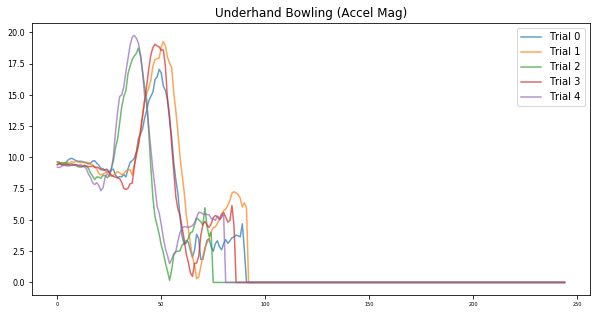

In [139]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()


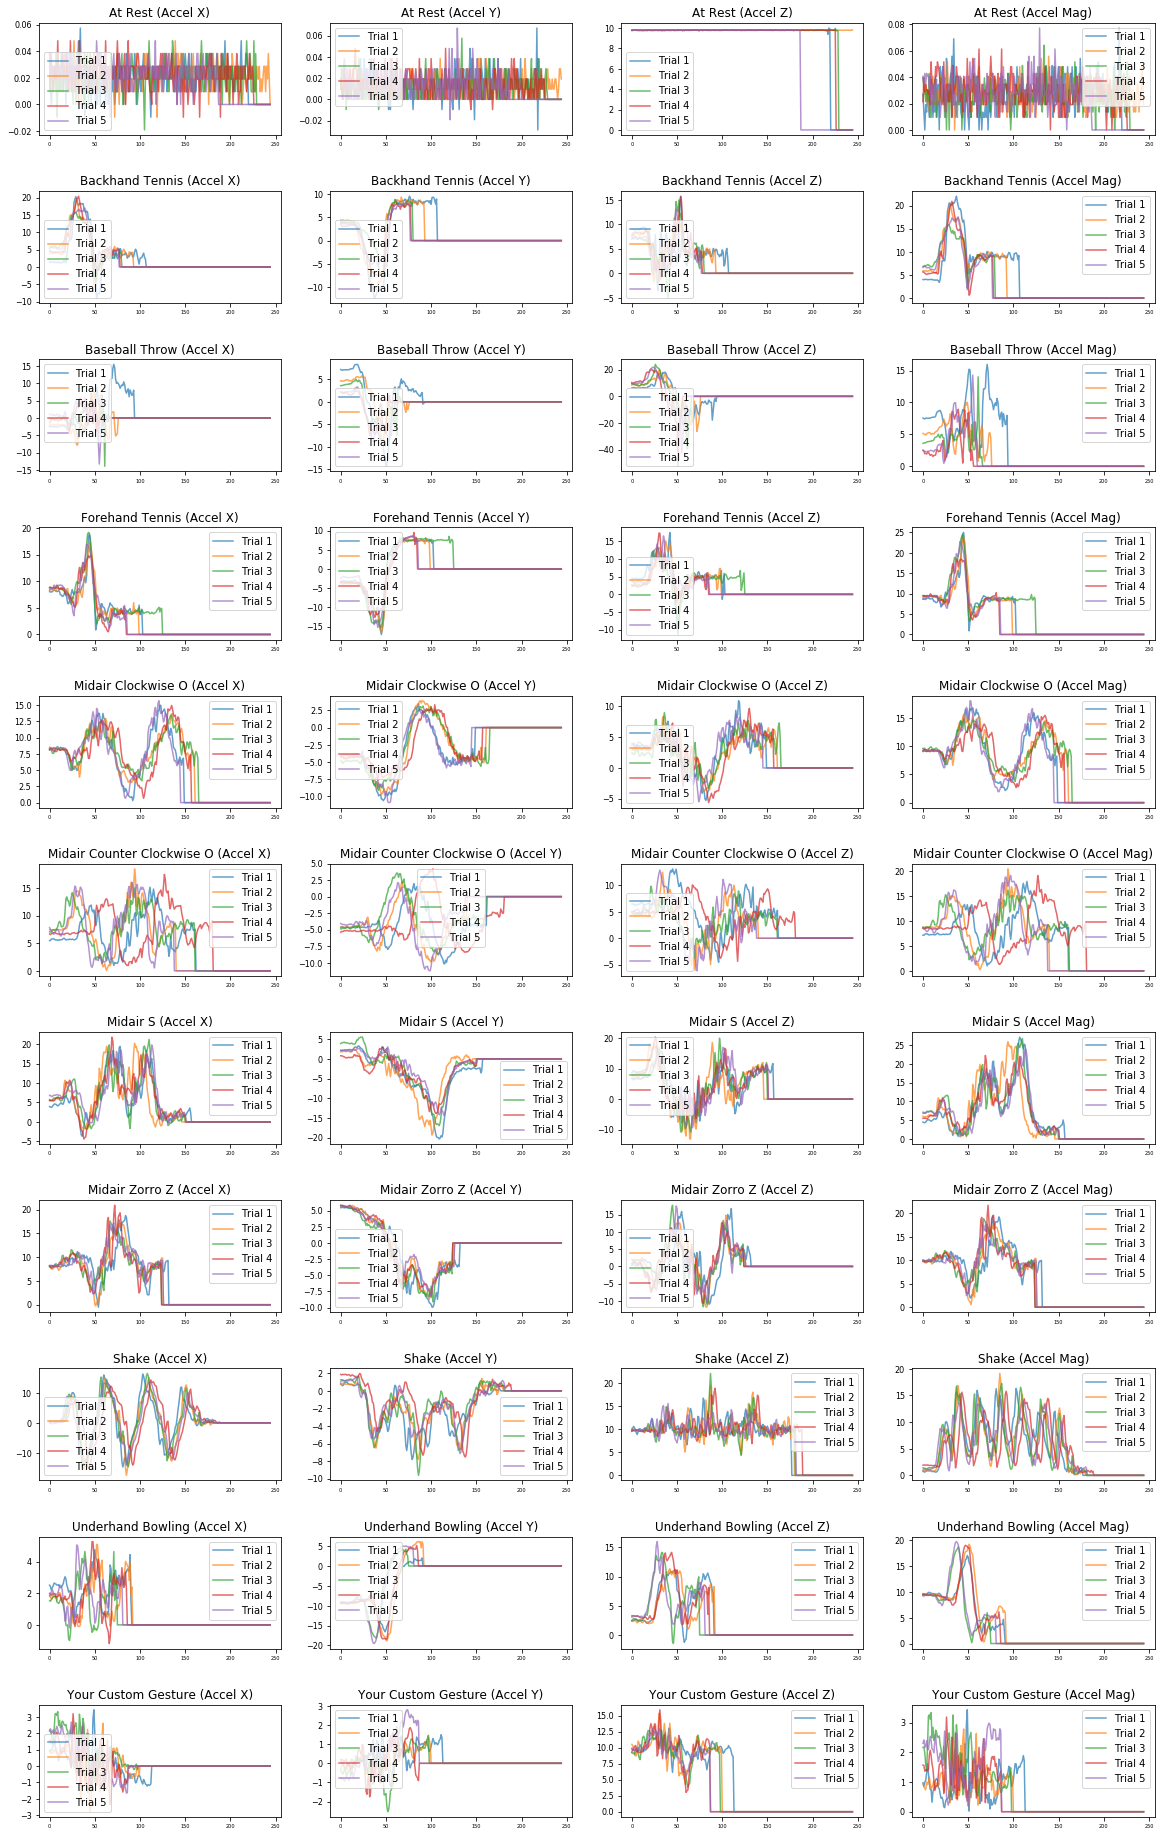

In [140]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1


In [6]:
# In class today, I'd like you to start analyzing and comparing these gesture signals.
# Think about:
#  - What kind of filtering might be useful?
#  - What kind of signal transforms? (e.g., ffts)
#  - Is there value in exploring both the accel data AND the gyro data? 
#  - What is the simplest way we can compare two signals? (scroll down and look for distance.euclidean)?
#  - What classes might you want to create to help you keep things organized? (e.g., your k-fold experiments and results)

# Sandbox
Everything below here is a Sandbox for you to play. You could do this in another Jupyter Notebook but I often have some cells at the bottom of my notebook that let's me experiment with and play with Python and the numpy, scipy, etc. libraries. I've added some example playground cells that I used when making the assignment.

Feel free to delete all of these cells but I thought they might be informative for you.

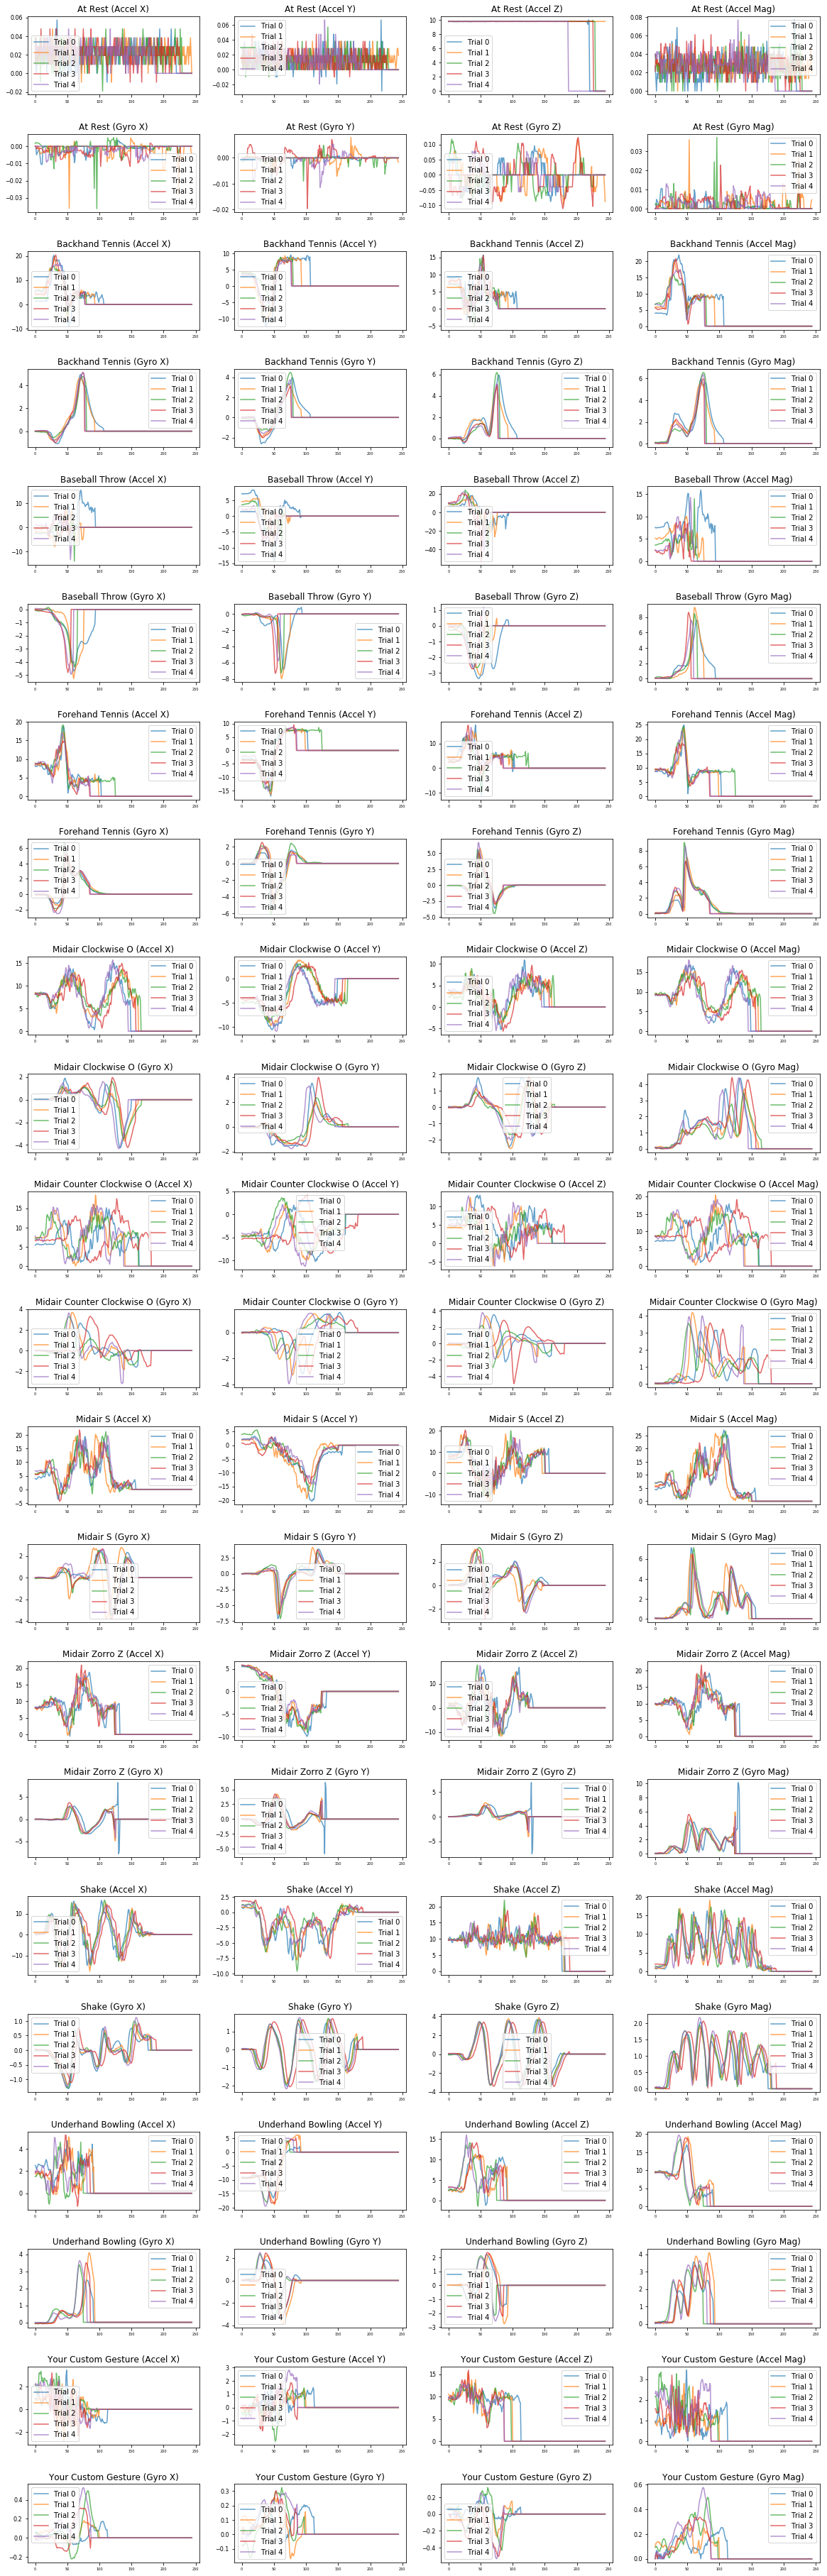

In [144]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials) * 2, 4, figsize=(20, 3 * len(mapGestureToTrials) * 2))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gesture_index in range(len(gestureNamesSorted)):
    
    gesture_name = gestureNamesSorted[gesture_index]
    gesture_trials = mapGestureToTrials[gesture_name]
    
    # Accelerometer
    axes_accelerometer_index = gesture_index * 2
    
    for trial_index in range(len(gesture_trials)):
        
        trial = gesture_trials[trial_index]
        
        trial_name = "Trial {}".format(trial_index)
        
        series = [trial.accel.x, trial.accel.y, trial.accel.z, trial.accel.mag]
        
        for i in range(len(series)):
             axes[axes_accelerometer_index][i].plot(series[i], alpha=0.7, label=trial_name)

    
    series_labels = ["X", "Y", "Z", "Mag"]
    
    for i in range(len(series_labels)):
        
        title = "{} (Accel {})".format(gesture_name, series_labels[i])
        axes[axes_accelerometer_index][i].set_title(title)
        axes[axes_accelerometer_index][i].legend()

    
    # Gyroscope
    axes_gyroscope_index = axes_accelerometer_index + 1
    
    for trial_index in range(len(gesture_trials)):
        
        trial = gesture_trials[trial_index]
        
        trial_name = "Trial {}".format(trial_index)
        
        series = [trial.gyro.x, trial.gyro.y, trial.gyro.z, trial.gyro.mag]
        
        for i in range(len(series)):
             axes[axes_gyroscope_index][i].plot(series[i], alpha=0.7, label=trial_name)

    
    series_labels = ["X", "Y", "Z", "Mag"]
    
    for i in range(len(series_labels)):
        
        title = "{} (Gyro {})".format(gesture_name, series_labels[i])
        axes[axes_gyroscope_index][i].set_title(title)
        axes[axes_gyroscope_index][i].legend()
    
    
    
    
    
    

In [49]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

gesture_names = gestureNamesSorted
gesture_trials_map = mapGestureToTrials


def score(a, b):
    distance, path = fastdtw(a, b, dist=euclidean)
    return distance

COMPARE_VALUE_COUNT = 5
GESTURE_TRIALS = 5

def score_compare_gesture_trial(gesture_trials_map, gesture_name_a, trial_index_a, gesture_name_b, trial_index_b):
    
    a = gesture_trials_map[gesture_name_a][trial_index_a]
    b = gesture_trials_map[gesture_name_b][trial_index_b]
    
    sx = score(a.accel.x, b.accel.x)
    sy = score(a.accel.y, b.accel.y)
    sz = score(a.accel.z, b.accel.z)
    sm = score(a.accel.mag, b.accel.mag)
    
    st = sx + sy + sz + sm
    # make sure that the number returned here is the same as COMPARE_VALUE_COUNT
    return (sx, sy, sz, sm, st)
    


def score_trial(gesture_trial_map, gesture_names, select_gesture_name, select_gesture_index):
    # Get all distances for a trial
    distances = []
    
    gesture_count = len(gesture_names)
    for gesture_index in range(gesture_count):

        gesture_name = gesture_names[gesture_index]
        gesture_trial_count = len(gesture_trials_map[gesture_name])

        
        for trial_index in range(gesture_trial_count):

            compare_gesture_name = gesture_name
            compare_gesture_index = trial_index
            s = score_compare_gesture_trial(gesture_trials_map, select_gesture_name, select_gesture_index, compare_gesture_name, compare_gesture_index)

            for i in s:      
                distances.append(i)

            print(select_gesture_name, select_gesture_index, compare_gesture_name, compare_gesture_index, s)
    return distances
    

def get_labels(gesture_trial_map, gesture_names):
    trials = []
    tick_indices = []
    tick_labels = []

    gesture_count = len(gesture_names)
    total_trials = 0
    for gesture_index in range(gesture_count):

        gesture_name = gesture_names[gesture_index]
        
        tick_indices.append(total_trials)
        tick_labels.append(gesture_name)

        gesture_trial_count = len(gesture_trials_map[gesture_name])
        for trial_index in range(gesture_trial_count):

            trial = total_trials
            for i in range(COMPARE_VALUE_COUNT):
                trials.append(trial)

            total_trials += 1

    return trials, tick_indices, tick_labels

trials, tick_indices, tick_labels = get_labels(gesture_trials_map, gesture_names)



In [93]:
# Figure out best gesture for a set of distances
# note: need to exclude the first best since this is the gesture compared against itself
# allowed gesture / trial array (gesture, trial) tuples

# must have the same number of trials

def select_best_fit_gesture_trial(gesture_names, distances, allowed_trials, exclude_trials):

    lowest_total = None
    best_trial = None
    
    for allowed_trial in allowed_trials:
        
        if allowed_trial in exclude_trials:
            continue
        
        trial_gesture = allowed_trial[0]
        trial_index = allowed_trial[1]
        
        gesture_index = gesture_names.index(trial_gesture)
        
        distance_start_index = gesture_index  * GESTURE_TRIALS * COMPARE_VALUE_COUNT + trial_index * COMPARE_VALUE_COUNT
        #print(gesture_index)
        #print(len(gesture_names))
        #print(GESTURE_TRIALS)
        #print(COMPARE_VALUE_COUNT)
        #print(trial_index)
        #print(distance_start_index)
        
        #sx = distance_start_index[0]
        #sy = distance_start_index[1]
        #sz = distance_start_index[2]
        #sm = distance_start_index[3]
        st = distances[distance_start_index + 4]
        #sx + sy + sz + sm
        total = st 
        
        if lowest_total == None or total < lowest_total:
            lowest_total = total
            best_trial = allowed_trial

    return best_trial


def predict_gesture(gesture_names, distances, allowed_trials, exclude_trials):
    best_fit = select_best_fit_gesture_trial(gesture_names, distances, allowed_trials, exclude_trials)
    return best_fit[0]



In [70]:
def all_trials(gesture_names):
    
    trial_list = set()
    
    for gesture_name in gesture_names:
        for i in range(GESTURE_TRIALS):
            
            trial_list.add((gesture_name, i))
    
    return trial_list


all_trial_list = all_trials(gesture_names)

print(all_trial_list)


{('Midair S', 0), ('Forehand Tennis', 0), ('Backhand Tennis', 2), ('At Rest', 1), ('Baseball Throw', 0), ('Underhand Bowling', 3), ('Midair Zorro Z', 4), ('Midair Counter Clockwise O', 0), ('Shake', 2), ('Midair Clockwise O', 2), ('Midair Zorro Z', 0), ('Your Custom Gesture', 3), ('Midair Counter Clockwise O', 4), ('Midair S', 3), ('Backhand Tennis', 3), ('At Rest', 2), ('Your Custom Gesture', 2), ('Underhand Bowling', 2), ('Forehand Tennis', 3), ('Midair Counter Clockwise O', 1), ('Backhand Tennis', 4), ('Shake', 3), ('Baseball Throw', 3), ('Midair Clockwise O', 3), ('Your Custom Gesture', 4), ('Midair S', 2), ('Backhand Tennis', 0), ('At Rest', 3), ('Midair Zorro Z', 3), ('Your Custom Gesture', 0), ('Forehand Tennis', 2), ('Shake', 4), ('Baseball Throw', 2), ('Underhand Bowling', 1), ('Midair Counter Clockwise O', 2), ('Backhand Tennis', 1), ('Shake', 0), ('Midair Clockwise O', 0), ('Midair Zorro Z', 2), ('Your Custom Gesture', 1), ('Midair S', 1), ('Underhand Bowling', 4), ('Forehan

In [94]:
import random

# create GESUTRE_TRIALS tuple list of sets of (gesture, index)
def generate_folds(gesture_names):
    
    folds = [set(),set(),set(),set(),set()]
    
    for gesture_name in gesture_names:
        
        trial_indices = []
        for i in range(GESTURE_TRIALS):
            trial_indices.append(i)
            
        random.shuffle(trial_indices)
        
        for i in range(GESTURE_TRIALS):
            folds[i].add((gesture_name, trial_indices[i]))
            
            
        
    return folds
    
    
    

In [95]:
folds = generate_folds(gesture_names)

for fold in folds:
    print(fold)

{('Midair S', 0), ('Midair Zorro Z', 2), ('Backhand Tennis', 2), ('At Rest', 3), ('Forehand Tennis', 1), ('Underhand Bowling', 2), ('Shake', 4), ('Midair Counter Clockwise O', 0), ('Midair Clockwise O', 2), ('Your Custom Gesture', 2), ('Baseball Throw', 4)}
{('Your Custom Gesture', 1), ('Forehand Tennis', 0), ('Midair Clockwise O', 4), ('Midair Zorro Z', 4), ('Baseball Throw', 2), ('Backhand Tennis', 4), ('Shake', 3), ('At Rest', 4), ('Underhand Bowling', 0), ('Midair Counter Clockwise O', 2), ('Midair S', 2)}
{('At Rest', 2), ('Midair S', 1), ('Midair Zorro Z', 3), ('Underhand Bowling', 4), ('Baseball Throw', 0), ('Midair Counter Clockwise O', 1), ('Midair Clockwise O', 3), ('Forehand Tennis', 4), ('Shake', 1), ('Your Custom Gesture', 3), ('Backhand Tennis', 0)}
{('Backhand Tennis', 3), ('Your Custom Gesture', 0), ('At Rest', 1), ('Forehand Tennis', 3), ('Midair Zorro Z', 1), ('Baseball Throw', 3), ('Midair S', 4), ('Underhand Bowling', 1), ('Shake', 0), ('Midair Clockwise O', 1), ('M

In [51]:
# Create Full distance Map

# go through each gesture trial and compare to all other gesture trials

gesture_trial_scores = {}

for gesture_name in gesture_names:
    
    gesture_trial_scores[gesture_name] = []
    
    for trial_index in range(len(gesture_trials_map[gesture_name])):
        
        select_gesture_name = gesture_name
        select_gesture_index = trial_index
        
        distances = score_trial(gesture_trials_map, gesture_names, select_gesture_name, select_gesture_index)
        
        gesture_trial_scores[gesture_name].append(distances)


print("Complete")



At Rest 0 At Rest 0 (0.019153614, 0.0, 0.0, 0.0, 0.019153614)
At Rest 0 At Rest 1 (1.3120225039999993, 1.9728220100000025, 3.246520499999974, 3.6497706422411715, 10.181135656241146)
At Rest 0 At Rest 2 (70.16926344700008, 810.4947387400019, 172.12392549999998, 737.8609767297339, 1790.6489044167358)
At Rest 0 At Rest 3 (29.793445843000004, 24.487894117000025, 5591.274930500004, 32.88488168825783, 5678.4411521482625)
At Rest 0 At Rest 4 (1.5897498969999995, 1342.8694220400002, 806.9225639999993, 1273.37706955921, 3424.75880549621)
At Rest 0 Backhand Tennis 0 (868.4631491960007, 883.0773541200044, 577.5963510659997, 1304.5284024429825, 3633.665256824987)
At Rest 0 Backhand Tennis 1 (836.4861897160006, 917.1612051600049, 653.1286278199997, 1323.2554794673483, 3730.0315021633533)
At Rest 0 Backhand Tennis 2 (764.1717188099996, 994.9248753100034, 640.7554564299992, 1299.0877564978232, 3698.939807047825)
At Rest 0 Backhand Tennis 3 (938.4121459760004, 1119.26056147, 601.9788753999998, 1513.21

At Rest 1 Baseball Throw 2 (1646.4829367220007, 1916.8840891300013, 1638.5629286799995, 2833.4411657977967, 8035.371120329797)
At Rest 1 Baseball Throw 3 (1929.0849212740006, 1892.1663567560004, 1699.6532106200004, 3046.4420974864734, 8567.346586136475)
At Rest 1 Baseball Throw 4 (1687.969665064002, 1922.9078811500015, 1937.4453504840005, 2838.304378163822, 8386.627274861827)
At Rest 1 Forehand Tennis 0 (952.873125715999, 1393.68397524, 1140.9808220300004, 1783.0806879013767, 5270.618610887375)
At Rest 1 Forehand Tennis 1 (1132.7447103020017, 1370.5655534699995, 1109.1379185039996, 1848.4349227959915, 5460.883105071993)
At Rest 1 Forehand Tennis 2 (1085.1575431040008, 1358.4413126600011, 930.6166149000003, 1878.6994170283617, 5252.914887692364)
At Rest 1 Forehand Tennis 3 (1159.818339118002, 1257.1857416660002, 1124.3171319299997, 1814.0654863482791, 5355.386699062281)
At Rest 1 Forehand Tennis 4 (1231.4337023920011, 1314.9817571600008, 1274.1749546770009, 1937.7123058092377, 5758.3027

At Rest 2 Midair Clockwise O 4 (418.56391568399977, 270.00848826000015, 440.15006087, 354.25874293680147, 1482.9812077508013)
At Rest 2 Midair Counter Clockwise O 0 (446.86337696099986, 435.63936945999995, 652.1613602799995, 473.6382723861408, 2008.3023790871398)
At Rest 2 Midair Counter Clockwise O 1 (470.29782738499995, 447.97429523599993, 539.2221372399998, 528.6020752651797, 1986.0963351261794)
At Rest 2 Midair Counter Clockwise O 2 (426.57970231799965, 482.6806246799998, 538.0633030969997, 501.7174309726468, 1949.041061067646)
At Rest 2 Midair Counter Clockwise O 3 (523.8992110469998, 552.28486266, 623.1915184999998, 651.6594696912176, 2351.035061898217)
At Rest 2 Midair Counter Clockwise O 4 (500.42646042999996, 594.7101198400004, 520.31751407, 662.9501039994793, 2278.40419833948)
At Rest 2 Midair S 0 (657.3903205889997, 506.8908130999996, 474.5499131299996, 854.5712807146441, 2493.402327533643)
At Rest 2 Midair S 1 (465.5573081889995, 509.1030363000002, 477.0207126259999, 697.72

At Rest 3 Midair Zorro Z 1 (968.0427854209988, 707.7164478800041, 4188.904826599996, 1378.365488291843, 7243.0295481928415)
At Rest 3 Midair Zorro Z 2 (803.2355179459985, 610.186239806005, 4047.4649659699944, 1138.413973955289, 6599.300697677288)
At Rest 3 Midair Zorro Z 3 (840.3552238219982, 567.6173311160044, 4160.002025009996, 1159.0011865304316, 6726.97576647843)
At Rest 3 Midair Zorro Z 4 (636.8672265109989, 520.2791809499996, 4056.5725091799945, 944.411476016737, 6158.13039265773)
At Rest 3 Shake 0 (2641.3886676690067, 1189.7650176400014, 4267.559151239996, 3047.0551415940704, 11145.767978143074)
At Rest 3 Shake 1 (4605.285275738994, 2409.3522116559993, 5220.5088763730055, 5512.665823991214, 17747.812187759213)
At Rest 3 Shake 2 (4288.561119938992, 2267.3090173760047, 4170.048098796994, 4915.35239630939, 15641.270632421381)
At Rest 3 Shake 3 (3127.3349852340107, 1709.7090071160012, 4005.441947389997, 3640.852849090605, 12483.338788830613)
At Rest 3 Shake 4 (2879.4489205490054, 14

At Rest 4 Underhand Bowling 3 (1317.2610506079996, 2170.774825429999, 976.3458667400004, 1952.013464777486, 6416.395207555484)
At Rest 4 Underhand Bowling 4 (1252.473948018999, 2005.0481964400003, 621.56349185, 1848.2093899696968, 5727.295026278696)
At Rest 4 Your Custom Gesture 0 (84.3620910120001, 1147.8760618349997, 400.03278439999997, 1019.6374272972884, 2651.9083645442884)
At Rest 4 Your Custom Gesture 1 (85.72199792100022, 1170.2666314559997, 340.26393820000055, 970.8766685066195, 2567.1292360836196)
At Rest 4 Your Custom Gesture 2 (117.65107274100006, 1178.5888771930004, 356.8509501000004, 820.7573957289625, 2473.848295762963)
At Rest 4 Your Custom Gesture 3 (95.95002668900028, 1099.3503808140015, 334.2975716000005, 884.4455663288402, 2414.043545431842)
At Rest 4 Your Custom Gesture 4 (110.09497136800026, 987.6656657249998, 290.9338149999997, 872.8722502455524, 2261.566702338552)
Backhand Tennis 0 At Rest 0 (868.4631491960007, 883.0773541200044, 577.5963510659997, 1304.528402442

Backhand Tennis 1 At Rest 2 (874.1709246109995, 934.1025881199995, 676.7833563199997, 974.082580831898, 3459.1394498828968)
Backhand Tennis 1 At Rest 3 (858.6756510739986, 928.3086087760053, 4090.828747679995, 1354.8967668549412, 7232.70977438494)
Backhand Tennis 1 At Rest 4 (834.1590256779997, 1187.179251620002, 707.4770247200004, 948.2940875085856, 3677.1093895265876)
Backhand Tennis 1 Backhand Tennis 0 (136.04811822000008, 67.07597238, 178.214807406, 90.15195269110671, 471.4908506971068)
Backhand Tennis 1 Backhand Tennis 1 (0.0, 0.0, 0.0, 0.0, 0.0)
Backhand Tennis 1 Backhand Tennis 2 (226.48191421200005, 301.18100189, 276.2621633100002, 312.9035247681788, 1116.8286041801791)
Backhand Tennis 1 Backhand Tennis 3 (318.687414996, 299.6870128499999, 269.6828810199999, 322.1938319278539, 1210.2511407938537)
Backhand Tennis 1 Backhand Tennis 4 (221.43493338200003, 240.1480089100002, 254.64730418, 329.96903944232577, 1046.199285914326)
Backhand Tennis 1 Baseball Throw 0 (884.8107609199999, 

Backhand Tennis 2 Baseball Throw 2 (944.7232649739998, 515.7110512199997, 2221.1009316100008, 668.5950337728315, 4350.130281576832)
Backhand Tennis 2 Baseball Throw 3 (998.3917151820001, 421.17840386599994, 2238.7892579500012, 527.6852841646136, 4186.044661162615)
Backhand Tennis 2 Baseball Throw 4 (857.1242115119996, 405.596925496, 2458.0119274139993, 537.8814046155658, 4258.614469037565)
Backhand Tennis 2 Forehand Tennis 0 (530.2390682219998, 495.82004205000015, 719.4288802599997, 552.2880630671688, 2297.7760535991683)
Backhand Tennis 2 Forehand Tennis 1 (490.01647093200006, 484.5768409999998, 967.8033767860003, 530.5591606585668, 2472.9558493765667)
Backhand Tennis 2 Forehand Tennis 2 (514.1500293219996, 421.82960881, 1094.7918328499993, 589.1369673595209, 2619.9084383415197)
Backhand Tennis 2 Forehand Tennis 3 (579.8373520919998, 417.57751975600013, 1064.27055275, 542.711687272403, 2604.397111870403)
Backhand Tennis 2 Forehand Tennis 4 (604.2294745319999, 468.68892825, 1373.5917718

Backhand Tennis 3 Midair Clockwise O 1 (555.1962134470002, 832.9427687099993, 321.73282102999997, 690.3265671935778, 2400.198370380577)
Backhand Tennis 3 Midair Clockwise O 2 (818.4434822680005, 763.11826976, 346.1441083600001, 708.4163042641378, 2636.122164652138)
Backhand Tennis 3 Midair Clockwise O 3 (390.17826061800014, 751.3866803199996, 311.14085996, 510.7804104410778, 1963.4862113390775)
Backhand Tennis 3 Midair Clockwise O 4 (523.9375265890004, 806.5778208999993, 368.04624397000015, 656.6210071921538, 2355.182598651154)
Backhand Tennis 3 Midair Counter Clockwise O 0 (543.3305601640002, 685.9962415499997, 519.7237329400001, 604.704189722176, 2353.754724376176)
Backhand Tennis 3 Midair Counter Clockwise O 1 (675.3755675119995, 787.7785455559996, 520.4132644599996, 722.6736428818148, 2706.2410204098137)
Backhand Tennis 3 Midair Counter Clockwise O 2 (609.3817905690001, 787.75940662, 510.91306643700005, 639.3944532716275, 2547.4487168976275)
Backhand Tennis 3 Midair Counter Clockwi

Backhand Tennis 4 Midair Counter Clockwise O 4 (433.50372607899976, 393.2236829099999, 353.70020007000005, 382.64370633397056, 1563.0713153929703)
Backhand Tennis 4 Midair S 0 (329.3751015200001, 581.1780990500004, 336.66306786999996, 479.33587417032055, 1726.552142610321)
Backhand Tennis 4 Midair S 1 (347.59019489600007, 686.5517061900003, 372.43243464600016, 488.8905821977586, 1895.4649179297594)
Backhand Tennis 4 Midair S 2 (487.957452385, 706.7587597999999, 406.1810948999999, 564.6039616050996, 2165.501268690099)
Backhand Tennis 4 Midair S 3 (287.93626021199964, 628.5832812800004, 425.35385940000003, 414.61423332530984, 1756.48763421731)
Backhand Tennis 4 Midair S 4 (360.0783483209996, 617.3018145099999, 344.6692720999999, 538.6095218409451, 1860.6589567719448)
Backhand Tennis 4 Midair Zorro Z 0 (467.8557525579998, 395.7902689700002, 320.07603785400005, 373.9313556826901, 1557.65341506469)
Backhand Tennis 4 Midair Zorro Z 1 (466.95552707200005, 534.0793658300003, 410.7779807999999,

Baseball Throw 0 Midair Zorro Z 3 (1128.406415659999, 1612.6480899, 1799.338328724, 862.2574398618995, 5402.650274145899)
Baseball Throw 0 Midair Zorro Z 4 (1092.5316986999994, 1726.7940576900005, 1714.0951714540001, 1080.6027419540405, 5614.02366979804)
Baseball Throw 0 Shake 0 (2507.3516755740015, 1753.95390117, 2275.0374894139995, 1669.1689969263712, 8205.512063084372)
Baseball Throw 0 Shake 1 (4204.4863426110005, 1993.728366124, 2844.6180302090006, 2157.7730615652326, 11200.605800509235)
Baseball Throw 0 Shake 2 (3999.5330947100024, 3557.1229549199993, 2284.5568181969993, 2466.836172045842, 12308.049039872843)
Baseball Throw 0 Shake 3 (2983.223202549997, 3055.1067319099993, 1958.054758014, 1915.2658786838326, 9911.650571157828)
Baseball Throw 0 Shake 4 (2813.838215526001, 2775.5405915160004, 2542.6804967159997, 2029.2751609149761, 10161.334464672977)
Baseball Throw 0 Underhand Bowling 0 (787.5870239730003, 702.5162402799998, 1585.3733240700003, 436.8660648404548, 3512.342653163455)

Baseball Throw 1 Underhand Bowling 2 (813.3581888950002, 767.1596870200001, 1754.4518454479992, 567.2635529278976, 3902.2332742908975)
Baseball Throw 1 Underhand Bowling 3 (1512.781134516, 564.9550006699999, 1129.3353660039998, 533.5305971171916, 3740.602098307191)
Baseball Throw 1 Underhand Bowling 4 (797.8054698140002, 569.2358212900002, 1072.07564744, 453.7100060681774, 2892.8269446121776)
Baseball Throw 1 Your Custom Gesture 0 (1796.7526020249995, 1702.8424342870003, 1484.4720828699997, 2727.079696499399, 7711.146815681399)
Baseball Throw 1 Your Custom Gesture 1 (1813.2438566010014, 1712.4096646200005, 1526.0832934699997, 2679.42082506088, 7731.157639751881)
Baseball Throw 1 Your Custom Gesture 2 (1654.0485955140014, 1619.0070684930006, 1502.8020832699997, 2609.5656187536547, 7385.423366030656)
Baseball Throw 1 Your Custom Gesture 3 (1713.0321575509997, 1637.7584595140006, 1520.2318815699996, 2636.8213772472322, 7507.843875882232)
Baseball Throw 1 Your Custom Gesture 4 (1704.882293

Baseball Throw 3 At Rest 0 (1930.4927118679952, 1895.2309349759996, 1706.0122001200004, 3049.180147268436, 8580.915994232431)
Baseball Throw 3 At Rest 1 (1929.0849212740006, 1892.1663567560004, 1699.6532106200004, 3046.4420974864734, 8567.346586136475)
Baseball Throw 3 At Rest 2 (1998.9956120210015, 1784.7720406439992, 1644.4430762200002, 2544.6883433716057, 7972.899072256607)
Baseball Throw 3 At Rest 3 (1952.8449789490041, 1912.756491588001, 4100.146986419996, 3084.39379126538, 11050.142248222382)
Baseball Throw 3 At Rest 4 (1928.2996231269992, 2063.888076544, 2043.6043864799997, 2402.750946789014, 8438.543032940011)
Baseball Throw 3 Backhand Tennis 0 (1011.5885198700007, 388.8662524239999, 1962.2206745060003, 448.16532657499897, 3810.840773375)
Baseball Throw 3 Backhand Tennis 1 (945.4032183399997, 407.76133401600003, 2137.1027215400013, 416.3567065488598, 3906.6239804448605)
Baseball Throw 3 Backhand Tennis 2 (998.3917151820001, 421.17840386599994, 2238.7892579500012, 527.6852841646

Baseball Throw 4 Backhand Tennis 4 (856.8560572680002, 770.693559436, 1477.0883520559998, 892.3701661401552, 3997.0081349001553)
Baseball Throw 4 Baseball Throw 0 (491.3093553200001, 374.098798696, 646.6834524419999, 363.8516691771314, 1875.9432756351316)
Baseball Throw 4 Baseball Throw 1 (476.44611909999986, 284.402434374, 656.1740803339998, 297.0700285188643, 1714.092662326864)
Baseball Throw 4 Baseball Throw 2 (478.98398073800007, 260.81476781400005, 562.8481048060006, 317.8818158832437, 1620.5286692412444)
Baseball Throw 4 Baseball Throw 3 (408.24010796999994, 205.72898682, 531.4361506359998, 251.3893791546424, 1396.794624580642)
Baseball Throw 4 Baseball Throw 4 (0.0, 0.0, 0.0, 0.0, 0.0)
Baseball Throw 4 Forehand Tennis 0 (912.1716985300003, 427.2883987639999, 1133.4150683579996, 408.02136295060563, 2880.8965286026055)
Baseball Throw 4 Forehand Tennis 1 (856.5112936, 450.8856210440001, 1290.6375021179988, 444.55989071294005, 3042.594307474939)
Baseball Throw 4 Forehand Tennis 2 (7

Forehand Tennis 0 Forehand Tennis 3 (294.63045774999995, 164.66361691400013, 333.60806957000017, 199.58822448029483, 992.490368714295)
Forehand Tennis 0 Forehand Tennis 4 (330.59137149000014, 202.08021368000007, 411.79310291299976, 277.2304296268693, 1221.6951177098692)
Forehand Tennis 0 Midair Clockwise O 0 (765.445447285, 1050.8247242200002, 697.4501087399999, 925.2605584625494, 3438.9808387075495)
Forehand Tennis 0 Midair Clockwise O 1 (845.4213484229999, 1273.3609738799996, 795.5453308799999, 1102.6563173898533, 4016.9839705728527)
Forehand Tennis 0 Midair Clockwise O 2 (900.8231766840003, 1105.469982419999, 724.3896737900003, 1116.9352995633694, 3847.618132457369)
Forehand Tennis 0 Midair Clockwise O 3 (814.2488493419996, 1118.3603731199994, 740.0381547899997, 985.9303285217245, 3658.577705773723)
Forehand Tennis 0 Midair Clockwise O 4 (876.0000980649999, 1314.8860129799996, 715.6556361399997, 1065.7256993839742, 3972.2674465689734)
Forehand Tennis 0 Midair Counter Clockwise O 0 (

Forehand Tennis 1 Midair Counter Clockwise O 1 (812.6303565580006, 1032.6096214059999, 848.236942736, 1088.3602504134133, 3781.8371711134137)
Forehand Tennis 1 Midair Counter Clockwise O 2 (975.120038853, 1060.25786743, 853.8489563930002, 1006.9802082453872, 3896.207070921387)
Forehand Tennis 1 Midair Counter Clockwise O 3 (888.7947124239998, 951.2067514099997, 864.2493699039999, 983.2846617929671, 3687.5354955309667)
Forehand Tennis 1 Midair Counter Clockwise O 4 (932.4362132669997, 912.0184607299998, 847.058985026, 925.7754756312116, 3617.289134654211)
Forehand Tennis 1 Midair S 0 (821.5846713279994, 1649.4134414499995, 944.2061261339998, 964.4684939865784, 4379.672732898577)
Forehand Tennis 1 Midair S 1 (770.7126889140001, 1606.1549932499993, 743.6773508420002, 1085.6831672732549, 4206.228200279254)
Forehand Tennis 1 Midair S 2 (1002.346909947, 1504.2386196299994, 701.165915204, 1186.3954020751542, 4394.146846856153)
Forehand Tennis 1 Midair S 3 (782.3868045900001, 1657.592024749999

Forehand Tennis 2 Midair Zorro Z 0 (784.1393626599995, 943.6506512099993, 730.2794144539997, 753.5960495705442, 3211.665477894543)
Forehand Tennis 2 Midair Zorro Z 1 (726.7934360820003, 1500.5898368600008, 824.8886862199997, 922.5010373953637, 3974.7729965573644)
Forehand Tennis 2 Midair Zorro Z 2 (693.0734841430001, 1456.871728830001, 1031.57532207, 944.44070380145, 4125.961238844451)
Forehand Tennis 2 Midair Zorro Z 3 (610.5214210700001, 1432.5657950000011, 927.1306736399997, 922.7500786956764, 3892.9679684056773)
Forehand Tennis 2 Midair Zorro Z 4 (803.8963115300004, 1263.6500731300007, 879.61055962, 928.9185737116485, 3876.0755179916496)
Forehand Tennis 2 Shake 0 (2458.3950329039994, 1688.5059528400002, 1501.6337368199995, 1687.796116744474, 7336.330839308473)
Forehand Tennis 2 Shake 1 (4181.722253061, 1656.279996986, 2822.256224773, 2351.0403700267284, 11011.298844846728)
Forehand Tennis 2 Shake 2 (4053.335579839999, 2527.9801139700003, 1567.8956582230007, 2549.4120669286817, 1069

Forehand Tennis 3 Shake 4 (2748.8308503460016, 1877.686196478, 1545.054970324001, 1951.5352531321028, 8123.107270280105)
Forehand Tennis 3 Underhand Bowling 0 (455.5686986529999, 449.180970506, 611.3833525159998, 356.1337469289032, 1872.266768603903)
Forehand Tennis 3 Underhand Bowling 1 (438.7614029169998, 545.7630815859999, 672.0811530300002, 382.36370375863197, 2038.969341291632)
Forehand Tennis 3 Underhand Bowling 2 (525.259116635, 589.9791887660006, 594.9878618280002, 427.40463089410827, 2137.630798123109)
Forehand Tennis 3 Underhand Bowling 3 (438.81885705600007, 429.54851051599996, 615.52053015, 357.5615498375079, 1841.4494475595081)
Forehand Tennis 3 Underhand Bowling 4 (365.5562971300001, 448.1754020059996, 617.6944647800003, 333.17500641990534, 1764.6011703359054)
Forehand Tennis 3 Your Custom Gesture 0 (1103.1523754250006, 1213.1994692170003, 905.0369877299999, 1690.7794923743827, 4912.168324746384)
Forehand Tennis 3 Your Custom Gesture 1 (1116.8088964010008, 1225.7833923880

Forehand Tennis 4 Your Custom Gesture 3 (1041.8033533309995, 1209.5123849860006, 952.691155777, 1744.6456600199185, 4948.652554113918)
Forehand Tennis 4 Your Custom Gesture 4 (1044.178398787, 1197.254071715, 1012.9963203770002, 1718.7383741305848, 4973.167165009585)
Midair Clockwise O 0 At Rest 0 (443.6455756600004, 605.4936141700034, 357.4734050500001, 834.6079242225629, 2241.220519102567)
Midair Clockwise O 0 At Rest 1 (443.16673533100027, 599.1729215900029, 354.9259775500001, 831.3542729721108, 2228.619907443114)
Midair Clockwise O 0 At Rest 2 (456.43061346400003, 255.22189271000002, 324.9314355500003, 414.99850117744637, 1451.5824429014467)
Midair Clockwise O 0 At Rest 3 (469.4646467579989, 609.4967199460044, 4108.564991449995, 868.097184248717, 6055.623542402715)
Midair Clockwise O 0 At Rest 4 (441.63444624199997, 398.50051300999996, 378.14980125000056, 326.7295692307298, 1545.0143297327304)
Midair Clockwise O 0 Backhand Tennis 0 (494.048313935, 693.6193915420001, 434.470991176000

Midair Clockwise O 1 Backhand Tennis 0 (603.846395203, 809.8243536319998, 407.96238219599985, 785.4286642825543, 2607.0617953135543)
Midair Clockwise O 1 Backhand Tennis 1 (558.2224871090002, 828.3363199200002, 449.70770049, 829.2728801631605, 2665.539387682161)
Midair Clockwise O 1 Backhand Tennis 2 (406.6312082569999, 1110.1338575900002, 402.13970451, 806.0197962400291, 2724.9245665970293)
Midair Clockwise O 1 Backhand Tennis 3 (555.1962134470002, 832.9427687099993, 321.73282102999997, 690.3265671935778, 2400.198370380577)
Midair Clockwise O 1 Backhand Tennis 4 (481.69421940099994, 543.4071708099999, 237.14088282999998, 516.6883537739961, 1778.930626814996)
Midair Clockwise O 1 Baseball Throw 0 (1210.891443073, 1709.0003424600006, 1800.8323150039996, 1751.9494067728165, 6472.673507309816)
Midair Clockwise O 1 Baseball Throw 1 (1427.7582075529997, 1742.0307217299999, 1472.7788058600004, 2016.8319097486042, 6659.399644891604)
Midair Clockwise O 1 Baseball Throw 2 (1217.6622436509995, 1

Midair Clockwise O 2 Baseball Throw 2 (1236.432783321999, 1939.5907046199995, 1931.8047266199997, 1694.2470526876987, 6802.0752672496965)
Midair Clockwise O 2 Baseball Throw 3 (1460.453433563999, 1905.5930393139988, 1879.6111259600002, 1895.6622246424813, 7141.3198234804795)
Midair Clockwise O 2 Baseball Throw 4 (1294.8225733739991, 1953.4100070639995, 2131.2417208240004, 1655.903155723402, 7035.377456985401)
Midair Clockwise O 2 Forehand Tennis 0 (900.8231766840003, 1105.469982419999, 724.3896737900003, 1116.9352995633694, 3847.618132457369)
Midair Clockwise O 2 Forehand Tennis 1 (872.8109971540005, 1246.6512505799992, 723.2021513960001, 1155.0568104523875, 3997.721209582387)
Midair Clockwise O 2 Forehand Tennis 2 (884.8203052840004, 1382.622750350001, 867.4384366399997, 1117.5814726002332, 4252.462964874234)
Midair Clockwise O 2 Forehand Tennis 3 (1005.7945406340008, 1086.9292676359996, 765.5220601300001, 1102.7897973948257, 3961.0356657948264)
Midair Clockwise O 2 Forehand Tennis 4 

Midair Clockwise O 3 Forehand Tennis 4 (867.0840881920001, 1106.829865860001, 894.5312070470003, 953.4947567589041, 3821.9399178579056)
Midair Clockwise O 3 Midair Clockwise O 0 (72.83160920499996, 95.72019243000003, 142.36882630999995, 90.2648388513109, 401.1854667963109)
Midair Clockwise O 3 Midair Clockwise O 1 (116.348616881, 69.14455146000006, 140.38640746999994, 79.24993244623622, 405.12950825723624)
Midair Clockwise O 3 Midair Clockwise O 2 (114.57691707400001, 70.69599138000002, 104.63620741999999, 103.63068696113876, 393.53980283513874)
Midair Clockwise O 3 Midair Clockwise O 3 (0.0, 0.0, 0.0, 0.0, 0.0)
Midair Clockwise O 3 Midair Clockwise O 4 (81.49863085899997, 49.89516622000002, 104.67449351000005, 83.56360620009616, 319.63189678909623)
Midair Clockwise O 3 Midair Counter Clockwise O 0 (238.23264304000006, 130.43611026000002, 151.73494337999998, 141.62129873566582, 662.0249954156659)
Midair Clockwise O 3 Midair Counter Clockwise O 1 (277.28686014000004, 151.84027197, 154.5

Midair Clockwise O 4 Midair Counter Clockwise O 1 (226.7021736540001, 146.87948278599995, 155.99661756999984, 154.56940317132734, 684.1476771813273)
Midair Clockwise O 4 Midair Counter Clockwise O 2 (191.07644993599993, 167.88142556999995, 147.1572269830001, 130.55373478236, 636.66883727136)
Midair Clockwise O 4 Midair Counter Clockwise O 3 (287.8500814969999, 211.9730355199999, 157.18412833000002, 184.81511272263816, 841.8223580696381)
Midair Clockwise O 4 Midair Counter Clockwise O 4 (287.1892858840002, 231.72041086000016, 164.77855190999995, 236.2066816745259, 919.8949303285262)
Midair Clockwise O 4 Midair S 0 (277.31559669300026, 283.01380793000004, 235.67563372, 414.62797043100005, 1210.6330087740002)
Midair Clockwise O 4 Midair S 1 (153.755634967, 273.04433148, 331.405409432, 310.26930006878916, 1068.4746759477891)
Midair Clockwise O 4 Midair S 2 (102.18452801099995, 227.4683135900002, 313.57338926999995, 259.3172576445149, 902.543488515515)
Midair Clockwise O 4 Midair S 3 (168.7

Midair Counter Clockwise O 0 Midair S 1 (271.35881912399975, 249.8876178799998, 382.7945606459999, 204.66039700594834, 1108.7013946559478)
Midair Counter Clockwise O 0 Midair S 2 (264.34859409000006, 255.30809693999998, 393.30988357999996, 191.57467253130662, 1104.5412471413065)
Midair Counter Clockwise O 0 Midair S 3 (289.54517501000004, 251.2092217699999, 440.1404721800001, 267.09399389669727, 1247.9888628566973)
Midair Counter Clockwise O 0 Midair S 4 (217.13493862899998, 184.64084576000008, 310.65246058000025, 158.55474794535303, 870.9829929143533)
Midair Counter Clockwise O 0 Midair Zorro Z 0 (557.1786291999998, 241.63241332000007, 452.130621894, 545.4805053433424, 1796.4221697573423)
Midair Counter Clockwise O 0 Midair Zorro Z 1 (449.6023546300001, 221.87546605999992, 455.7219324600005, 382.57160706349737, 1509.771360213498)
Midair Counter Clockwise O 0 Midair Zorro Z 2 (356.0082178200001, 238.32841087999984, 359.33137321000004, 403.83120574937027, 1357.4992076593703)
Midair Coun

Midair Counter Clockwise O 1 Midair S 4 (213.275493641, 241.4025747260001, 353.72893014, 204.86458923734526, 1013.2715877443453)
Midair Counter Clockwise O 1 Midair Zorro Z 0 (908.9538919280005, 269.903141342, 348.3563619939999, 500.12534313248113, 2027.3387383964814)
Midair Counter Clockwise O 1 Midair Zorro Z 1 (508.3369016360002, 310.8823060160003, 501.6427162400001, 441.7169442355221, 1762.5788681275226)
Midair Counter Clockwise O 1 Midair Zorro Z 2 (401.785352635, 263.7644176500001, 337.01742127000017, 408.3361865496275, 1410.9033781046276)
Midair Counter Clockwise O 1 Midair Zorro Z 3 (406.05661444799995, 277.449662036, 374.0892121, 341.67658571430354, 1399.2720742983033)
Midair Counter Clockwise O 1 Midair Zorro Z 4 (282.10400114799984, 340.39801713400016, 356.1327117399999, 339.5952164658936, 1318.2299464878934)
Midair Counter Clockwise O 1 Shake 0 (2408.5956460939997, 937.569385606, 1412.2916892600003, 1647.0483054664728, 6405.505026426473)
Midair Counter Clockwise O 1 Shake 1

Midair Counter Clockwise O 2 Midair Zorro Z 3 (435.94582693299986, 311.90701077999967, 359.39840106699995, 355.527288253125, 1462.7785270331246)
Midair Counter Clockwise O 2 Midair Zorro Z 4 (300.44358459699987, 360.00174455000007, 315.75689301700004, 372.47795890082654, 1348.6801810648265)
Midair Counter Clockwise O 2 Shake 0 (2418.6321442449985, 931.8424511100001, 1422.0025719299995, 1644.2654341538007, 6416.742601438799)
Midair Counter Clockwise O 2 Shake 1 (4452.1234049540035, 1998.1241345539997, 3050.979102437, 3179.7440370807626, 12680.970679025766)
Midair Counter Clockwise O 2 Shake 2 (4079.1450850829992, 1969.1064071800013, 1374.0802451630009, 2822.372687127672, 10244.704424553674)
Midair Counter Clockwise O 2 Shake 3 (2975.446832353, 1499.4406258399995, 1671.4592273670003, 2067.5604758847976, 8213.907161444797)
Midair Counter Clockwise O 2 Shake 4 (2736.859844549, 1245.3296422840008, 1544.758077207001, 1829.6432090692429, 7356.590773109245)
Midair Counter Clockwise O 2 Underha

Midair Counter Clockwise O 3 Shake 2 (4076.051776574001, 1964.4808104199997, 1639.3290384830002, 2528.024878719933, 10207.886504196933)
Midair Counter Clockwise O 3 Shake 3 (2975.178677913999, 1531.6953193999993, 1534.0128956299989, 1855.0787194268628, 7895.965612370859)
Midair Counter Clockwise O 3 Shake 4 (2724.9941856400014, 1201.9371412040002, 1486.5789930540002, 1709.1155498048681, 7122.625869702871)
Midair Counter Clockwise O 3 Underhand Bowling 0 (874.2667004110003, 1014.6243684599997, 543.493373114, 848.5411804182754, 3280.9256224032756)
Midair Counter Clockwise O 3 Underhand Bowling 1 (830.4432315389992, 1357.5410860600002, 746.1960573370001, 1283.5588991368334, 4217.739274072833)
Midair Counter Clockwise O 3 Underhand Bowling 2 (1012.1631497490001, 1246.8715033599995, 486.14743989799985, 1125.7457690656156, 3870.927862072615)
Midair Counter Clockwise O 3 Underhand Bowling 3 (954.4820243019998, 1525.2022634499992, 1038.00134142, 1433.7860165082616, 4951.47164568026)
Midair Cou

Midair Counter Clockwise O 4 Underhand Bowling 1 (772.3215717059999, 1274.787906340001, 698.3407336870001, 1108.5358371488678, 3853.9860488818686)
Midair Counter Clockwise O 4 Underhand Bowling 2 (706.5001978639996, 1154.3691417599998, 475.35438116800003, 1089.0526173462022, 3425.2763381382015)
Midair Counter Clockwise O 4 Underhand Bowling 3 (857.7658517849999, 1441.2328330299988, 798.4087967300004, 1371.4928135548064, 4468.900295099806)
Midair Counter Clockwise O 4 Underhand Bowling 4 (828.6332045289997, 1371.6764781200002, 554.12361492, 1292.07421942118, 4046.50751699018)
Midair Counter Clockwise O 4 Your Custom Gesture 0 (464.714550676, 702.2001978090002, 417.92227597, 845.1373878898651, 2429.9744123448654)
Midair Counter Clockwise O 4 Your Custom Gesture 1 (468.70807992999994, 706.835371836, 355.96031987, 856.4173720965833, 2387.9211437325835)
Midair Counter Clockwise O 4 Your Custom Gesture 2 (515.1077098449999, 671.5256863530002, 432.63224317, 793.382100105174, 2412.647739473174

Midair S 1 At Rest 2 (465.5573081889995, 509.1030363000002, 477.0207126259999, 697.7294750148232, 2149.410532129823)
Midair S 1 At Rest 3 (494.62291713399884, 914.8053111220048, 3981.825529373995, 1122.9445416323529, 6514.198299262351)
Midair S 1 At Rest 4 (468.6218867010004, 360.7391489999997, 372.7867650259996, 408.5324254858437, 1610.6802262128435)
Midair S 1 Backhand Tennis 0 (563.7674638139998, 958.6096230679999, 544.4127265200001, 773.3774194367135, 2840.167232838713)
Midair S 1 Backhand Tennis 1 (457.3212475539999, 951.6472753200001, 564.5335903060001, 774.0082346204574, 2747.5103478004576)
Midair S 1 Backhand Tennis 2 (315.0865261799999, 1327.7955175099994, 574.1870363239999, 824.7226431182448, 3041.791723132244)
Midair S 1 Backhand Tennis 3 (393.34818511799995, 1025.9154197899998, 454.33328372600016, 711.8117670069619, 2585.408655640962)
Midair S 1 Backhand Tennis 4 (347.59019489600007, 686.5517061900003, 372.43243464600016, 488.8905821977586, 1895.4649179297594)
Midair S 1 Ba

Midair S 2 Baseball Throw 4 (1346.6618478170008, 2072.478445613999, 2073.685111544001, 1826.4286765506117, 7319.2540815256125)
Midair S 2 Forehand Tennis 0 (872.4566804170004, 1259.9055680999995, 835.0113454300001, 1151.0425664256475, 4118.416160372647)
Midair S 2 Forehand Tennis 1 (1002.346909947, 1504.2386196299994, 701.165915204, 1186.3954020751542, 4394.146846856153)
Midair S 2 Forehand Tennis 2 (968.550343937, 1372.777785650001, 1200.328241, 1211.4737328982822, 4753.130103485283)
Midair S 2 Forehand Tennis 3 (1088.0305933470001, 1302.4744612760012, 889.69492953, 1025.967699360897, 4306.167683513899)
Midair S 2 Forehand Tennis 4 (1045.8256101470001, 1273.8206421700004, 880.8651185770003, 1033.055915663471, 4233.567286557472)
Midair S 2 Midair Clockwise O 0 (154.67500942300003, 252.66488203000011, 278.1679349500002, 258.9311218709855, 944.4389482739858)
Midair S 2 Midair Clockwise O 1 (103.190089366, 246.34419316000003, 269.8935708699999, 229.48904654589415, 848.9168999418941)
Midai

Midair S 3 Midair Counter Clockwise O 1 (302.38767511000015, 307.396331804, 404.52432064000027, 321.17903387938253, 1335.487361433383)
Midair S 3 Midair Counter Clockwise O 2 (269.2710791729998, 266.3022539099999, 400.11898669699985, 341.17787708233925, 1276.8701968623386)
Midair S 3 Midair Counter Clockwise O 3 (361.208420094, 314.78005205000017, 379.76828269999993, 356.23260130775657, 1411.9893561517567)
Midair S 3 Midair Counter Clockwise O 4 (285.331382707, 322.6043037299999, 410.58642376999984, 296.59762395729484, 1315.1197341642946)
Midair S 3 Midair S 0 (189.87933946399994, 140.25233591000008, 200.73945513000012, 194.12121805570362, 724.9923485597037)
Midair S 3 Midair S 1 (107.28897073400003, 176.58672928999994, 215.72715342599997, 156.5188059450358, 656.1216593950357)
Midair S 3 Midair S 2 (164.491233633, 116.26243767999996, 135.89488180000006, 177.40331706578263, 594.0518701787827)
Midair S 3 Midair S 3 (0.0, 0.0, 0.0, 0.0, 0.0)
Midair S 3 Midair S 4 (135.9044677649999, 113.8

Midair S 4 Midair Zorro Z 3 (477.22186665699985, 206.78243791999995, 189.68781743999998, 312.79850876156286, 1186.4906307785627)
Midair S 4 Midair Zorro Z 4 (352.44564485499995, 241.57496523, 168.17829161999998, 219.68689781095688, 981.8857995159568)
Midair S 4 Shake 0 (2396.7874520049995, 989.6384840099998, 1490.3905631599996, 1561.37487736375, 6438.191376538749)
Midair S 4 Shake 1 (4390.544542120998, 2102.3485295539995, 3183.4071870069997, 3252.9528189000894, 12929.253077582085)
Midair S 4 Shake 2 (4043.653444306999, 2000.1544250899994, 1557.4952456830008, 2929.3662589010532, 10530.669373981053)
Midair S 4 Shake 3 (2948.057165195001, 1542.8427345399998, 1493.7807405700003, 2130.0350251467135, 8114.715665451715)
Midair S 4 Shake 4 (2696.1584145549987, 1254.5808519839993, 1465.3567785539994, 1855.9277195425611, 7272.023764635559)
Midair S 4 Underhand Bowling 0 (567.1384967919998, 1354.1125930399999, 357.66500731400015, 1045.271087721265, 3324.1871848672645)
Midair S 4 Underhand Bowling

Midair Zorro Z 0 Underhand Bowling 3 (786.3803527160004, 1696.2344823499998, 708.4251346940001, 941.5625739483833, 4132.602543708384)
Midair Zorro Z 0 Underhand Bowling 4 (773.260115312, 1654.0294772200004, 518.9288397640001, 838.3739661472576, 3784.5923984432584)
Midair Zorro Z 0 Your Custom Gesture 0 (889.053286095, 466.75441246300016, 374.55850125399996, 1098.4415640297993, 2828.8077638417994)
Midair Zorro Z 0 Your Custom Gesture 1 (902.5661602810004, 478.34234803400017, 329.0973876540001, 1117.2693723429745, 2827.275268311975)
Midair Zorro Z 0 Your Custom Gesture 2 (889.417204804, 474.1668612270001, 373.457129154, 1056.4407929382846, 2793.4819881232847)
Midair Zorro Z 0 Your Custom Gesture 3 (902.7864272409996, 438.51241005199984, 377.94866655399994, 1078.872380413896, 2798.1198842608956)
Midair Zorro Z 0 Your Custom Gesture 4 (894.8759831890002, 439.27855497099983, 376.14823655399994, 1050.7607685568144, 2761.063543270814)
Midair Zorro Z 1 At Rest 0 (944.7902985180006, 699.4803932

Midair Zorro Z 2 At Rest 2 (865.7433346039988, 269.5487996499993, 383.5128235300001, 712.4817859114506, 2231.286743695449)
Midair Zorro Z 2 At Rest 3 (803.2355179459985, 610.186239806005, 4047.4649659699944, 1138.413973955289, 6599.300697677288)
Midair Zorro Z 2 At Rest 4 (778.3262434779998, 350.60689665000007, 453.26067653000007, 650.2149437641401, 2232.40876042214)
Midair Zorro Z 2 Backhand Tennis 0 (506.7950393620001, 756.5006953180001, 478.56261118600014, 598.583935828296, 2340.4422816942965)
Midair Zorro Z 2 Backhand Tennis 1 (490.073936087, 798.5907582699996, 542.72721255, 648.7697654719437, 2480.161672378943)
Midair Zorro Z 2 Backhand Tennis 2 (362.779024919, 1012.2110113100002, 491.4051014100001, 622.2904530928568, 2488.685590731857)
Midair Zorro Z 2 Backhand Tennis 3 (301.1905686829999, 810.2170008899998, 398.52923546999995, 440.32985365758736, 1950.2666587005872)
Midair Zorro Z 2 Backhand Tennis 4 (386.83595896500003, 519.1969947499999, 332.82276533, 341.89415896757174, 1580.

Midair Zorro Z 3 Baseball Throw 1 (1161.9060795999999, 1845.0484353499996, 1716.2307898599997, 1138.4635237865066, 5861.648828596506)
Midair Zorro Z 3 Baseball Throw 2 (1123.148750262, 2029.9478695699997, 1937.7040496699992, 1112.9737384494306, 6203.7744079514305)
Midair Zorro Z 3 Baseball Throw 3 (993.3542973699992, 1993.690086163999, 1974.8620382100005, 1265.6498499369548, 6227.556271680954)
Midair Zorro Z 3 Baseball Throw 4 (1001.7818728999999, 2015.515596513999, 2214.5790944739997, 1154.8430714418603, 6386.719635329859)
Midair Zorro Z 3 Forehand Tennis 0 (609.9563918399999, 1074.11550826, 757.58286915, 882.0295694694968, 3323.6843387194967)
Midair Zorro Z 3 Forehand Tennis 1 (811.41410474, 1091.2005182900002, 833.996220714, 837.5698001789142, 3574.180643922914)
Midair Zorro Z 3 Forehand Tennis 2 (610.5214210700001, 1146.4203775800006, 927.1306736399997, 922.7500786956764, 3606.8225509856766)
Midair Zorro Z 3 Forehand Tennis 3 (676.9461632400004, 1005.2774154460006, 949.05197804, 72

Midair Zorro Z 4 Midair Clockwise O 0 (295.4444912109998, 251.0751414600001, 222.30641213000004, 297.9375655792042, 1066.7636103802042)
Midair Zorro Z 4 Midair Clockwise O 1 (392.227694239, 178.32014087000002, 187.0158877699999, 322.23351301515834, 1079.7972358941583)
Midair Zorro Z 4 Midair Clockwise O 2 (415.7004414140001, 187.24572839, 265.9000354400001, 349.2623755435432, 1218.1085807875436)
Midair Zorro Z 4 Midair Clockwise O 3 (361.1413752720003, 197.04280499, 242.3985614999998, 268.4318560014973, 1069.0145977634975)
Midair Zorro Z 4 Midair Clockwise O 4 (397.0256745150001, 200.97886972999993, 266.59914459, 424.02179138341313, 1288.625480218413)
Midair Zorro Z 4 Midair Counter Clockwise O 0 (243.68185035800005, 310.02996893000005, 329.65284645999986, 292.7882992169714, 1176.1529649649715)
Midair Zorro Z 4 Midair Counter Clockwise O 1 (282.10400114799984, 340.39801713400016, 356.1327117399999, 339.5952164658936, 1318.2299464878934)
Midair Zorro Z 4 Midair Counter Clockwise O 2 (30

Shake 0 Midair S 0 (2333.8295118920005, 1080.9054675900002, 1373.60139119, 1459.958665686221, 6248.295036358222)
Shake 0 Midair S 1 (2353.11720983, 1125.33226327, 1378.8399144380003, 1722.0061869646747, 6579.295574502676)
Shake 0 Midair S 2 (2447.33382946, 1074.8337554900002, 1497.9753794599999, 1648.5339283492274, 6668.6768927592275)
Shake 0 Midair S 3 (2344.612999556002, 1065.5729755599998, 1489.6818687599998, 1574.3731155081427, 6474.240959384144)
Shake 0 Midair S 4 (2396.7874520049995, 989.6384840099998, 1490.3905631599996, 1561.37487736375, 6438.191376538749)
Shake 0 Midair Zorro Z 0 (2275.8994050039987, 902.1830875099992, 1373.371551306, 1152.1475155091673, 5703.601559329165)
Shake 0 Midair Zorro Z 1 (2306.7750322619986, 1074.34534603, 1415.3083956200005, 1271.6922855197051, 6068.121059431704)
Shake 0 Midair Zorro Z 2 (2304.7926411030007, 1066.9616224200001, 1421.62907691, 1308.2561599149417, 6101.639500347943)
Shake 0 Midair Zorro Z 3 (2465.625534913999, 960.6399133699992, 1421.

Shake 1 Underhand Bowling 0 (4302.667753932003, 1596.5781986339994, 2913.4561457369973, 2002.6847568116364, 10815.386855114633)
Shake 1 Underhand Bowling 1 (4380.479321102002, 1651.654405613999, 2995.701776644, 2117.089733462312, 11144.925236822313)
Shake 1 Underhand Bowling 2 (4249.976166138002, 1645.5252409539994, 2924.708907271, 2105.9609601014877, 10926.171274464488)
Shake 1 Underhand Bowling 3 (4296.768451152002, 1766.3079395039983, 2920.753676082998, 2674.038245166226, 11657.868311905226)
Shake 1 Underhand Bowling 4 (4223.620796842997, 1720.3201219939997, 2871.758736572999, 2217.1361795203125, 11032.835834930309)
Shake 1 Your Custom Gesture 0 (4554.853810802998, 2290.9349969050013, 3182.0376794070003, 5207.590555040496, 15235.417042155495)
Shake 1 Your Custom Gesture 1 (4587.529874644, 2283.445931227999, 3155.845127207, 5151.631071143307, 15178.452004222307)
Shake 1 Your Custom Gesture 2 (4553.158717315006, 2271.0535451390006, 3144.716860807, 4997.114117218846, 14966.043240479852

Shake 3 At Rest 3 (3127.3349852340107, 1709.7090071160012, 4005.441947389997, 3640.852849090605, 12483.338788830613)
Shake 3 At Rest 4 (3101.506337333006, 1649.5570755200006, 1600.4472276700003, 2735.968047960536, 9087.478688483543)
Shake 3 Backhand Tennis 0 (2926.58596091, 1779.8016489879997, 1415.2509218559999, 1754.1719775630374, 7875.810509317037)
Shake 3 Backhand Tennis 1 (2872.486586049999, 1798.045460700001, 1516.7267625699997, 1792.816666258314, 7980.075475578315)
Shake 3 Backhand Tennis 2 (2857.3169176420033, 1834.23621143, 1961.5215556000005, 1826.3734947984944, 8479.448179470497)
Shake 3 Backhand Tennis 3 (2900.709422226, 1705.96445835, 1925.0147691700006, 1811.3716497407509, 8343.060299486751)
Shake 3 Backhand Tennis 4 (2925.6665925219986, 1574.2642259700003, 1772.6764962700001, 1699.0211637463017, 7971.628478508301)
Shake 3 Baseball Throw 0 (2983.223202549997, 3055.1067319099993, 1958.054758014, 1915.2658786838326, 9911.650571157828)
Shake 3 Baseball Throw 1 (3062.97883326

Shake 4 Forehand Tennis 1 (2872.9845897059977, 2387.9097382339996, 1437.938379508, 1911.8141193222482, 8610.646826770246)
Shake 4 Forehand Tennis 2 (2785.4333937759993, 2283.838564104001, 1703.3117088940003, 1950.813215638325, 8723.396882412326)
Shake 4 Forehand Tennis 3 (2761.3956206460016, 1892.530248278, 1545.054970324001, 1951.5352531321028, 8150.516092380105)
Shake 4 Forehand Tennis 4 (2766.8927078060005, 1900.3449275439998, 1733.4403389140002, 1951.1744490129731, 8351.852423276974)
Shake 4 Midair Clockwise O 0 (2781.487762377, 1243.2802081840005, 1542.7469619039996, 1798.1193540936401, 7365.63428655864)
Shake 4 Midair Clockwise O 1 (2771.3938083989997, 1235.3314633240002, 1489.7489087240003, 1997.6322619917103, 7494.1064424387105)
Shake 4 Midair Clockwise O 2 (2774.7073833780014, 1244.8029221540005, 1484.4816671139993, 1929.058292608143, 7433.050265254144)
Shake 4 Midair Clockwise O 3 (2753.0254891059994, 1217.9495573039999, 1500.1301640060012, 1788.011953428723, 7259.11716384472

Underhand Bowling 0 Midair Counter Clockwise O 1 (665.003892512, 1212.4333268240002, 595.6773885739997, 1052.7752242767704, 3525.88983218677)
Underhand Bowling 0 Midair Counter Clockwise O 2 (707.4004045180004, 1178.7229714200007, 581.6952570369996, 937.9603519978714, 3405.778984972872)
Underhand Bowling 0 Midair Counter Clockwise O 3 (874.2667004110003, 1014.6243684599997, 543.493373114, 848.5411804182754, 3280.9256224032756)
Underhand Bowling 0 Midair Counter Clockwise O 4 (573.0952729579997, 921.3845837399998, 542.143036644, 861.2085025919171, 2897.8313959339166)
Underhand Bowling 0 Midair S 0 (541.4151774090003, 1317.9314215400002, 376.205714344, 937.5742871922051, 3173.126600485206)
Underhand Bowling 0 Midair S 1 (499.12402575099986, 1487.48879478, 421.6668051099999, 1019.3595889855796, 3427.6392146265794)
Underhand Bowling 0 Midair S 2 (786.0930337199994, 1537.4988692399997, 362.6832636140002, 1141.3364026144504, 3827.6115691884497)
Underhand Bowling 0 Midair S 3 (509.88834319699

Underhand Bowling 1 Midair S 3 (782.5112988269999, 1641.6753792899988, 565.9126654970003, 1208.2660830586872, 4198.365426672686)
Underhand Bowling 1 Midair S 4 (796.2923280049997, 2185.2932485800006, 434.020874677, 1344.8644843894474, 4760.470935651448)
Underhand Bowling 1 Midair Zorro Z 0 (815.6949455169997, 1327.0772719399995, 535.4296894170003, 626.9272881298192, 3305.1291950038185)
Underhand Bowling 1 Midair Zorro Z 1 (813.4539674730001, 1617.49395768, 509.648930743, 1036.819707977019, 3977.416563873019)
Underhand Bowling 1 Midair Zorro Z 2 (780.404405334, 1637.4136997799992, 543.5795501130002, 965.5463111689133, 3926.9439663959124)
Underhand Bowling 1 Midair Zorro Z 3 (757.4871131489998, 1567.6849688599996, 529.415459153, 941.5811863263197, 3796.1687274883193)
Underhand Bowling 1 Midair Zorro Z 4 (776.928008257, 1822.8111051300004, 460.25174790299997, 960.4251615404473, 4020.4160228304477)
Underhand Bowling 1 Shake 0 (2546.118587735, 1787.8845210899997, 1618.3079666329998, 1598.62

Underhand Bowling 2 Shake 1 (4249.976166138002, 1645.5252409539994, 2924.708907271, 2105.9609601014877, 10926.171274464488)
Underhand Bowling 2 Shake 2 (4015.708313077001, 2629.8007552999984, 1446.6054012810005, 2553.4878280311495, 10645.602297689149)
Underhand Bowling 2 Shake 3 (2902.0885035650012, 2274.1181173300006, 1440.3900506679997, 1788.867532025736, 8405.464203588737)
Underhand Bowling 2 Shake 4 (2806.3874563569993, 2295.2254298639987, 2020.1890806840015, 1864.4171427114159, 8986.219109616415)
Underhand Bowling 2 Underhand Bowling 0 (276.740986954, 224.91130793999992, 447.47629131199983, 286.3598364873089, 1235.4884226933086)
Underhand Bowling 2 Underhand Bowling 1 (206.456798935, 126.61497470000003, 532.6619919750001, 174.61938924754907, 1040.3531548575493)
Underhand Bowling 2 Underhand Bowling 2 (0.0, 0.0, 0.0, 0.0, 0.0)
Underhand Bowling 2 Underhand Bowling 3 (313.6691558640001, 322.4128218799998, 427.8246951440002, 376.11651171010124, 1440.0231845981016)
Underhand Bowling 2

Underhand Bowling 3 Underhand Bowling 4 (211.27394722600005, 185.41656061000018, 382.9477726840001, 260.7194973223006, 1040.357777842301)
Underhand Bowling 3 Your Custom Gesture 0 (1119.1360734970006, 2247.8776971390002, 983.0400691400002, 2574.834400978444, 6924.888240754445)
Underhand Bowling 3 Your Custom Gesture 1 (1218.1219438370006, 2260.068971769999, 995.6622996400002, 2552.6635821210766, 7026.516797368076)
Underhand Bowling 3 Your Custom Gesture 2 (1149.9829606179994, 2161.245904213001, 996.9360074400005, 2417.8489671517195, 6726.01383942272)
Underhand Bowling 3 Your Custom Gesture 3 (1158.5254769650007, 2173.5042206640014, 1039.82094344, 2458.2093270926966, 6830.059968161699)
Underhand Bowling 3 Your Custom Gesture 4 (1197.6371566870002, 2220.3731086149983, 1015.6873953400003, 2475.580509958113, 6909.2781706001115)
Underhand Bowling 4 At Rest 0 (1254.9256105379961, 2216.07311245999, 694.0215094500003, 2608.1077605992095, 6773.127993047196)
Underhand Bowling 4 At Rest 1 (1253.7

Your Custom Gesture 0 At Rest 1 (84.51531993300033, 83.26075972500004, 102.56760500000003, 109.48692443252331, 379.8306090905237)
Your Custom Gesture 0 At Rest 2 (109.376710322, 587.1157243349999, 132.80158649999984, 455.63130066651377, 1284.9253218235135)
Your Custom Gesture 0 At Rest 3 (110.31523742700027, 112.91055302099983, 4301.882418499998, 149.86258179667257, 4674.97079074467)
Your Custom Gesture 0 At Rest 4 (84.3620910120001, 1147.8760618349997, 400.03278439999997, 1019.6374272972884, 2651.9083645442884)
Your Custom Gesture 0 Backhand Tennis 0 (888.7659805250004, 833.3737249369998, 483.513818266, 1167.4188157570493, 3373.0723394850493)
Your Custom Gesture 0 Backhand Tennis 1 (791.714615825, 842.2418447350003, 563.3843846199999, 1199.7698729556066, 3397.1107181356065)
Your Custom Gesture 0 Backhand Tennis 2 (609.9180924749996, 861.127307819, 591.7413217300004, 1104.0420144504506, 3166.8287364744506)
Your Custom Gesture 0 Backhand Tennis 3 (874.0176971989998, 967.0180639389998, 4

Your Custom Gesture 1 Backhand Tennis 2 (676.2374787259992, 869.5357423439998, 495.34117373000004, 1063.9058950946, 3105.020289894599)
Your Custom Gesture 1 Backhand Tennis 3 (878.3559870549997, 979.8988670439995, 460.79761659999997, 1253.523822419649, 3572.576293118648)
Your Custom Gesture 1 Backhand Tennis 4 (759.345004449, 616.5739719740003, 339.83298250000007, 1024.353174849015, 2740.1051337720155)
Your Custom Gesture 1 Baseball Throw 0 (1529.0233957810003, 1871.2314528339998, 1685.0965992339998, 2540.16966054567, 7625.52110839467)
Your Custom Gesture 1 Baseball Throw 1 (1813.2438566010014, 1712.4096646200005, 1526.0832934699997, 2679.42082506088, 7731.157639751881)
Your Custom Gesture 1 Baseball Throw 2 (1573.8428520930001, 1823.8071003860007, 1726.8898002799997, 2639.857067954784, 7764.396820713784)
Your Custom Gesture 1 Baseball Throw 3 (1867.3240891110013, 1800.0853574920004, 1763.9328538200004, 2782.7480958844376, 8214.09039630744)
Your Custom Gesture 1 Baseball Throw 4 (1618.

Your Custom Gesture 2 Baseball Throw 3 (1723.4708693240007, 1721.3831612509994, 1736.3229248200005, 2664.0672878125324, 7845.244243207533)
Your Custom Gesture 2 Baseball Throw 4 (1453.7688462140002, 1773.6246169770009, 1971.2707268840006, 2508.9427194247323, 7707.606909499735)
Your Custom Gesture 2 Forehand Tennis 0 (742.652636624, 1284.8818733730002, 861.5104056300002, 1553.993285044404, 4443.038200671404)
Your Custom Gesture 2 Forehand Tennis 1 (903.475947914, 1275.4295550049994, 738.3335087040001, 1646.1930745538566, 4563.432086176856)
Your Custom Gesture 2 Forehand Tennis 2 (898.5055739440004, 1251.650339941, 887.2241139999999, 1649.6965757592527, 4687.076603644253)
Your Custom Gesture 2 Forehand Tennis 3 (949.6936130140001, 1160.7951814909993, 838.9378627299999, 1623.6887169537156, 4573.115374188715)
Your Custom Gesture 2 Forehand Tennis 4 (971.3276205139999, 1198.1351374369997, 1099.8196409770003, 1691.1948059052233, 4960.477204833223)
Your Custom Gesture 2 Midair Clockwise O 0 (

Your Custom Gesture 3 Midair Clockwise O 0 (369.24336301400007, 434.6721126639997, 167.62284245000006, 610.4192298951089, 1581.9575480231088)
Your Custom Gesture 3 Midair Clockwise O 1 (263.37176480200003, 433.4271226140001, 195.59669696999998, 473.6050339234227, 1366.0006183094229)
Your Custom Gesture 3 Midair Clockwise O 2 (316.8773809229997, 354.399313484, 258.85151914000005, 494.2979209035986, 1424.4261344505983)
Your Custom Gesture 3 Midair Clockwise O 3 (367.222650441, 403.17398880999986, 345.19599653999984, 573.0372882371336, 1688.6299240281332)
Your Custom Gesture 3 Midair Clockwise O 4 (321.8764740459999, 436.8556180499999, 385.72504016999983, 539.2942095609786, 1683.7513418269782)
Your Custom Gesture 3 Midair Counter Clockwise O 0 (364.2346880490001, 514.7916738519999, 457.65643807999993, 657.1502545944288, 1993.8330545754286)
Your Custom Gesture 3 Midair Counter Clockwise O 1 (412.47306730699984, 599.7475283319999, 388.65556743999997, 730.2481521578022, 2131.124315236802)
Yo

Your Custom Gesture 4 Midair Counter Clockwise O 1 (500.28280882299987, 566.1137841710002, 402.89629254000016, 706.3952903297358, 2175.688175863736)
Your Custom Gesture 4 Midair Counter Clockwise O 2 (383.5989895540002, 596.405226365, 403.99758459699996, 758.6615126544089, 2142.6633131704093)
Your Custom Gesture 4 Midair Counter Clockwise O 3 (509.1605030750001, 618.3073762909999, 429.85498959999984, 861.5703608219123, 2418.8932297879123)
Your Custom Gesture 4 Midair Counter Clockwise O 4 (517.9807502199999, 630.556108625, 389.50786877, 806.5088075279458, 2344.5535351429457)
Your Custom Gesture 4 Midair S 0 (646.0896862469996, 673.7475179769999, 405.19472143000013, 1034.1314386720808, 2759.16336432608)
Your Custom Gesture 4 Midair S 1 (461.19028195700014, 689.9227377909999, 426.0529682259999, 852.3904365082096, 2429.55642448221)
Your Custom Gesture 4 Midair S 2 (327.06710437199973, 529.4346092649997, 333.8666386999999, 580.3475007830327, 1770.715853120032)
Your Custom Gesture 4 Midair 

275


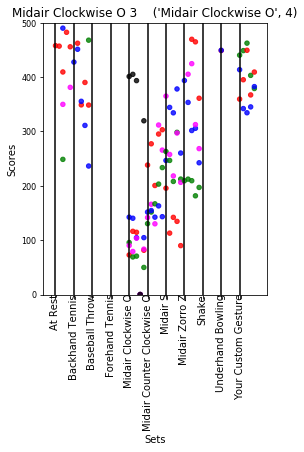

In [86]:
# Create chart of charts that displays all of the scores in comparison
# close up of a specific gesture
trial_gesture = gesture_names[4]
trial_index = 3

distances = gesture_trial_scores[trial_gesture][trial_index]

allowed_trials = all_trial_list
exclude_trials = set([(trial_gesture, trial_index)])

print(len(distances))
best_fit = select_best_fit_gesture_trial(gesture_names, distances, allowed_trials, exclude_trials)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(4, 5))

x = trials
y = distances

# x y x m distances
colors = ['red', 'green', 'blue', 'magenta', 'black']
area = 20

axes.set_title("{} {}    {}".format(trial_gesture, trial_index, best_fit))
axes.set_xticks(tick_indices)
axes.set_xticklabels(tick_labels, fontdict={'fontsize':10,  'verticalalignment': 'baseline', 'rotation':90})
axes.set(xlabel="Sets")
axes.set(ylabel="Scores")

axes.set_ylim(0, 500)

axes.vlines(tick_indices, 0, 6000)
axes.scatter(x, y, s=area, c=colors, alpha=0.8)


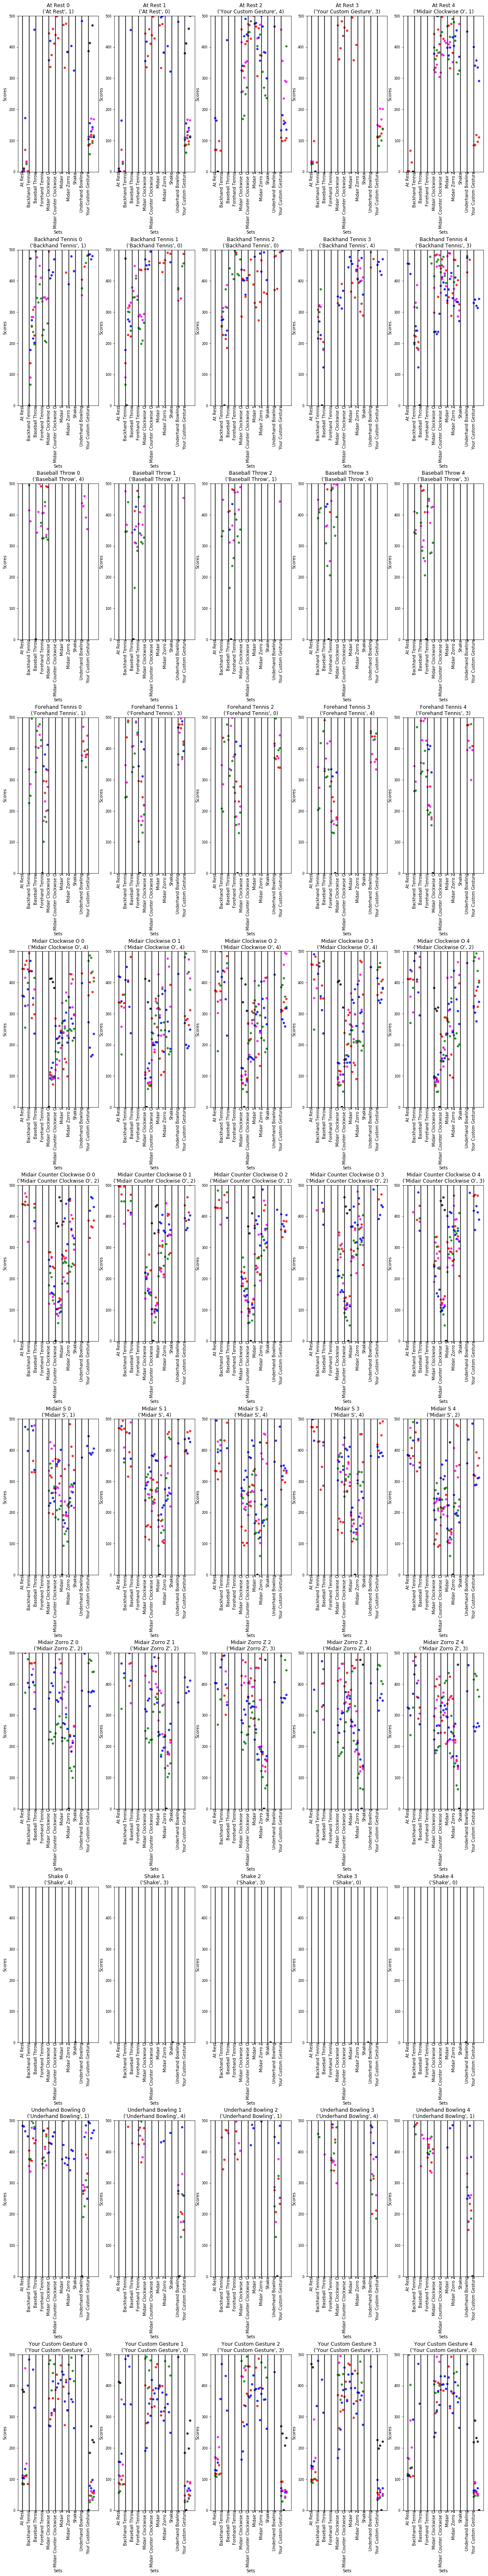

In [96]:
# Create chart of charts that displays all of the scores in comparison


# Now let's plot all of the comparison scores! :)

# We are going to make a grid of scatter plots with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)

gesture_count = len(gesture_names)

fig, axes = plt.subplots(gesture_count, GESTURE_TRIALS, figsize=(20, 10 * gesture_count))
fig.subplots_adjust(hspace=0.5)

index = 0

for gesture_index in range(gesture_count):
    
    gesture_name = gesture_names[gesture_index]
    
    for trial_index in range(GESTURE_TRIALS):
        
    
        distances = gesture_trial_scores[gesture_name][trial_index]
        
        allowed_trials = all_trial_list
        exclude_trials = set([(gesture_name, trial_index)])

        best_fit = select_best_fit_gesture_trial(gesture_names, distances, allowed_trials, exclude_trials)

        x = trials
        y = distances

        # x y x m t distances
        colors = ['red', 'green', 'blue', 'magenta', 'black']
        area = 20

        title = "{} {}\n{}".format(gesture_name, trial_index, best_fit)
        
        select_axes = axes[gesture_index][trial_index]
    
        select_axes.set_title(title)
        select_axes.set_xticks(tick_indices)
        select_axes.set_xticklabels(tick_labels, fontdict={'fontsize':10,  'verticalalignment': 'baseline', 'rotation':90})
        select_axes.set(xlabel="Sets")
        select_axes.set(ylabel="Scores")

        select_axes.set_ylim(0, 500)

        select_axes.vlines(tick_indices, 0, 6000)
        select_axes.scatter(x, y, s=area, c=colors, alpha=0.8)
        



In [108]:
# Cross fold validation



# use one fold as test and the rest as training \ example data
# return a tuple (true list, predicted list)
def true_v_predicted(gesture_names, gesture_trial_scores, training_folds, test_fold):
    # test using training and test data
    
    true_values = []
    predicted_values = []
    
    # which can be used to reference from the distance set
    allowed_trials = set()
    excluded_trials = test_fold
    
    for training in training_folds:
        allowed_trials = allowed_trials.union(training)
    
    for test in test_fold:
        
        # look up comparisions in cache
        gesture_name = test[0]
        trial_index = test[1]
        
        distances = gesture_trial_scores[gesture_name][trial_index]

        actual_gesture = gesture_name
        predicted_gesture = predict_gesture(gesture_names, distances, allowed_trials, exclude_trials)
    
        true_values.append(actual_gesture)
        predicted_values.append(predicted_gesture)
    
    
    return (true_values, predicted_values)
    

# returns true and predicted values
def cross_fold_validation():
    
    
    # wrap it in a loop
    # Do cross fold validation
    folds = generate_folds(gesture_names)
    fold_count = len(folds)

    true_values = []
    predicted_values = []

    for i in range(fold_count):

        test_fold = folds[i]
        training_folds = []
        for t in range(fold_count):
            if t == i:
                continue
            training_folds.append(folds[t])

        #print("\nTest:")
        #print(test_fold)
        #print("\nTraining:")
        #print(training_folds)

        fold_true_values, fold_predicted_values = true_v_predicted(gesture_names, gesture_trial_scores, training_folds, test_fold)

        true_values += fold_true_values
        predicted_values += fold_predicted_values

    return (true_values, predicted_values)
        
    
    
true_values, predicted_values = cross_fold_validation()

In [109]:

for i in range(len(true_values)):
    actual = true_values[i]
    predicted = predicted_values[i]
    print(actual == predicted, "|", actual, "|", predicted)

True | Midair S | Midair S
True | Forehand Tennis | Forehand Tennis
True | Midair Zorro Z | Midair Zorro Z
True | Underhand Bowling | Underhand Bowling
True | Baseball Throw | Baseball Throw
True | Midair Counter Clockwise O | Midair Counter Clockwise O
False | At Rest | Midair Clockwise O
True | Shake | Shake
True | Midair Clockwise O | Midair Clockwise O
True | Backhand Tennis | Backhand Tennis
True | Your Custom Gesture | Your Custom Gesture
True | Your Custom Gesture | Your Custom Gesture
True | Underhand Bowling | Underhand Bowling
True | At Rest | At Rest
True | Baseball Throw | Baseball Throw
True | Midair Zorro Z | Midair Zorro Z
True | Backhand Tennis | Backhand Tennis
True | Shake | Shake
True | Forehand Tennis | Forehand Tennis
True | Midair Counter Clockwise O | Midair Counter Clockwise O
True | Midair Clockwise O | Midair Clockwise O
True | Midair S | Midair S
True | Backhand Tennis | Backhand Tennis
True | Midair Zorro Z | Midair Zorro Z
True | Your Custom Gesture | Your 

In [123]:

# count total accuracies

gesture_count = len(gesture_names)

correct_predictions = [0] * gesture_count
actual_values = [0] * gesture_count


prediction_count = len(true_values)
for i in range(prediction_count):
    actual = true_values[i]
    predicted = predicted_values[i]
    
    
    gesture_index = gesture_names.index(actual)
    
    actual_values[gesture_index] += 1
    
    if actual == predicted:
        correct_predictions[gesture_index] += 1
    

total_correct = sum(correct_predictions)
total_values = sum(actual_values)
percent = (float(total_correct) / float(total_values)) * 100
print("{:<40} {}/{} ({:.1f}%)".format("Compare Euclidean Distance Accuracy",total_correct, total_values, percent))

for i in range(gesture_count):

    correct = correct_predictions[i]
    actual = actual_values[i]
    percent = (float(correct) / float(actual)) * 100
    
    print("{:<40} {}/{} ({:.1f}%)".format(gesture_names[i], correct, actual, percent))
    

Compare Euclidean Distance Accuracy      52/55 (94.5%)
At Rest                                  2/5 (40.0%)
Backhand Tennis                          5/5 (100.0%)
Baseball Throw                           5/5 (100.0%)
Forehand Tennis                          5/5 (100.0%)
Midair Clockwise O                       5/5 (100.0%)
Midair Counter Clockwise O               5/5 (100.0%)
Midair S                                 5/5 (100.0%)
Midair Zorro Z                           5/5 (100.0%)
Shake                                    5/5 (100.0%)
Underhand Bowling                        5/5 (100.0%)
Your Custom Gesture                      5/5 (100.0%)


Confusion matrix, without normalization
[[2 0 0 0 2 0 0 0 0 0 1]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 5]]
Normalized confusion matrix
[[0.4 0.  0.  0.  0.4 0.  0.  0.  0.  0.  0.2]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


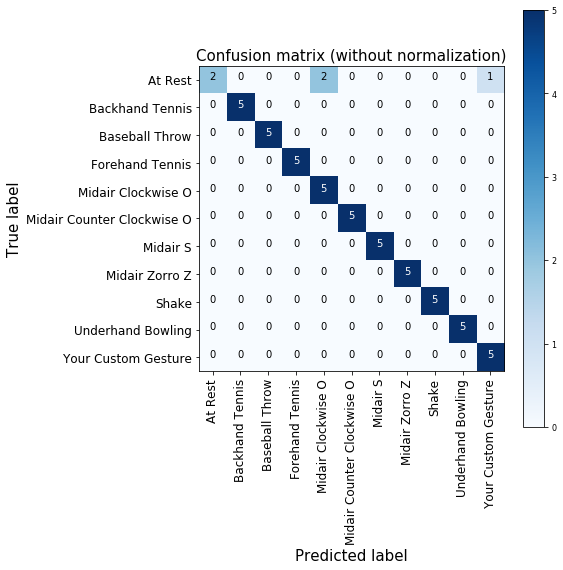

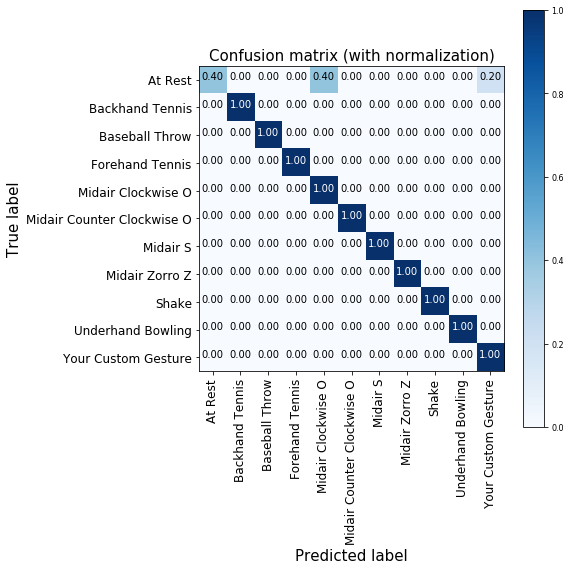

In [134]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, size=12)
    plt.yticks(tick_marks, classes, size=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=15)
    plt.xlabel('Predicted label', size=15)
    
y_true = true_values
y_pred = predicted_values
labels = gesture_names
cm = confusion_matrix(y_true, y_pred, labels)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()